In [69]:
# coding: utf-8
import os
import re
import datetime

import _main as pp

import turbodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")

def to_pivot(df):
    pvt = pd.DataFrame()
    cols = ['Preis_Konkurrenz',
            'Txt_Kurz_Konkurrenz',
            'Txt_Lang_Konkurrenz',
            'Joined_on',
            'Preisdifferenz',
            'Closest', 'Distance']
    for i in cols:
        pvt_ = df.pivot(index='UID', columns='Konkurrenz', values=i)
        pvt_.columns = [i + '_' + j for j in pvt_.columns]
        pvt = pd.concat([pvt, pvt_], axis=1)
    pvt = df.merge(
        pvt, left_on='UID',
        right_index=True)
    pvt.drop(cols, axis=1, inplace=True)
    pvt.drop('Konkurrenz', axis=1, inplace=True)
    pvt.drop_duplicates(inplace=True)
    return pvt.reset_index(drop=True)


def load_price_group():
    f = os.path.join(pp.Path, "Dotdat", "Output")
    folders = os.listdir(f)
    folders.sort(reverse=True)
    folder = folders[0]
    df = pd.read_csv(os.path.join(f, folder, "KOMWGR.csv"),
        sep="\t", dtype=str)
    df['Warengruppe_Bezeichnung'] = df["Text deutsch"]
    df = df[df.groupby(
        'Warengruppe')['Warengruppe_Bezeichnung'].rank(method='dense')==1]
    return df.drop_duplicates()


def join_price_group(df):
    priceg = load_price_group()
    df = df.merge(priceg[["Warengruppe", "Warengruppe_Bezeichnung"]],
        how="left", on="Warengruppe")
    return df.drop_duplicates()


def get_companies(df):
    companies = [i[17:] for i in df.columns if i.startswith(
        "Preis_") and not i.endswith("Log")]
    return companies


def prep_df(df):
    companies = get_companies(df)

    for i in df:
        try:
            if df[i].dtype == 'O':
                df[i] = df[i].str.replace("\r", "")
                df[i] = df[i].str.replace("\n", " ")
                df[i] = df[i].str.replace('"', "")
                df[i] = df[i].str.strip()
        except AttributeError:
            continue

    for j, i in enumerate(companies):
        print("{} Company in data: {}".format(j+1, i))

    df['Discount_perc'] = (df['GrossSales_LTM'] -
                           df['Sales_LTM']) / df['GrossSales_LTM']
    df['Margin_perc'] = df['Margin_LTM'] / df['Sales_LTM']
    df['ProCasa'] = (df['Art_Txt_Lang']
                      .str.lower()
                      .str.replace(" ", "")
                      .str.contains("procasa"))

    for i in ['GrossSales_LTM', 'Sales_LTM',
              'Margin_LTM', 'Quantity_LTM',
              'ObjectRate', 'CountOfOrders', 'Preis',
              'CountOfCustomers', 'Discount_perc',
              'Margin_perc', 'SalesConsequents_LTM']:
        df[i] = df[i].astype(np.float)
        df[i + '_Log'] = df[i].apply(lambda x: np.log(x + 1))

    df['GrossSales_Calculated'] = df['Preis'] * df['Quantity_LTM']

    for i in companies:
        df['Preis_Konkurrenz_' +
            i] = df['Preis_Konkurrenz_' + i].astype(np.float)
        df['Preis_Konkurrenz_' + i + '_Log'] = df['Preis_Konkurrenz_' +
            i].apply(lambda x: np.log(x + 1))
        df['Outlier_' + i] = np.nan
        df['GrossSales_Calculated_' + i] = df['Preis_Konkurrenz_' + i] * \
            df['Quantity_LTM']
    return df.drop_duplicates()


def cluster(df, X=None, tag='', clusters=5, scaler_obj=StandardScaler):
    if tag in df.columns:
        df[tag] = np.nan
    if not X:
        X = df
    else:
        X = df[X]
    norm = scaler_obj()
    normalized = norm.fit_transform(X)
    kmeans = KMeans(
        n_clusters=clusters, random_state=23).fit(normalized)
    df[tag] = kmeans.labels_
    return df.drop_duplicates()


def map_cluster(df):
    cluster_cols = [i for i in df.columns if i.startswith("Cluster")]
    for i in cluster_cols:
        cols = re.sub("_Log|Cluster_", "", i).split("_&_")
        #grouped = df[df[i]!='Nicht zugeordnet'].groupby(i)
        grouped = df.groupby(i)[cols].mean()

        mp = {1: "(1) Low", 2: "(2) Low", 3: "(2) High", 4: "(1) High"}

        grouped[cols[0]+'_rank'] = grouped[cols[0]].rank().map(mp)
        grouped[cols[1]+'_rank'] = grouped[cols[1]].rank().map(mp)

        grouped['Cluster'] = grouped[[cols[0]+'_rank', cols[1]+'_rank']].apply(
            lambda x: "{} {}, {} {}".format(
                x[0], cols[0].split("_")[0],
                x[1], cols[1].split("_")[0]), axis=1)

        df[i] = df[i].map(grouped['Cluster']).fillna("Nicht zugeordnet")
    return df

def get_cluster(df, plot=True):
    for i in [['Margin_perc', 'Sales_LTM_Log', StandardScaler, 4, 0.0001, np.log(100)],
              ['Quantity_LTM_Log', 'Sales_LTM_Log', StandardScaler, 4, 1, np.log(100)],
              ['ObjectRate', 'Sales_LTM_Log', StandardScaler, 4, 0.0001, np.log(100)],
              ['SalesConsequents_LTM_Log', 'Sales_LTM_Log', StandardScaler, 4, 1, np.log(100)]]:

        tag = 'Cluster_' + '_&_'.join(i[:2])

        dfs = df.query("{} > {} and {} > {}".format(
            i[0], i[4], i[1], i[5])).copy()
        
        dfs = (dfs.pipe(cluster, X=[i[0], i[1]],
                       tag=tag, clusters=i[3], scaler_obj=i[2])
                   .pipe(map_cluster))
        #print(grouped)

        #dfs[tag] = dfs[tag].map(i[4])
        #dfs[tag] = dfs[tag] + 1

        if plot:
            splt = sns.lmplot(i[0], i[1],
                       data=dfs, hue=tag,
                       fit_reg=False, size=7,
                       aspect=1.6,
                       palette=sns.color_palette('colorblind'))
            splt._legend.set_title("Cluster")

            plt.savefig(os.path.join(pp.Path, "Plots", "PDF", tag + ".pdf"))
            plt.savefig(os.path.join(pp.Path, "Plots", "PNG", tag + ".png"))

        df[tag] = "Nicht zugeordnet"
        df.update(dfs[tag])
    return df.drop_duplicates()


def outlier_detection(df, threshold=1.5):
    companies = get_companies(df)
    for i in companies:
        df_temp = df[['Preis', 'Preis_Konkurrenz_' + i]
            ].replace('', np.nan).dropna(how='any').copy()
        df_temp['Preis'] = df_temp['Preis'].astype(np.float)
        df_temp['Preis_Konkurrenz_' +
            i] = df_temp['Preis_Konkurrenz_' + i].astype(np.float)
        df_temp['Diff'] = df_temp['Preis'] - df_temp['Preis_Konkurrenz_' + i]
        df['Outlier_' + i] = False
        df_temp['Outlier_' + i] = (np.abs(
                df_temp['Diff']) / df_temp['Preis']) > threshold * (
                np.std(df_temp['Diff']) / df_temp['Preis'])
        df.update(df_temp)
    return df.drop_duplicates()


def plot_outlier(df):
    for i in get_companies(df):
        dfplot = df[(df['Joined_on_' + i] != 'Text_Similarity') & (pd.notnull(
            df['Preis_Konkurrenz_' + i]))]
        f, ax = plt.subplots(figsize=(20, 20))
        p1 = sns.regplot('Preis_Konkurrenz_' + i, 'Preis',
                         data=dfplot, fit_reg=False)
        for line in range(0, dfplot.shape[0]):
            if dfplot.Outlier_Sanitas.iloc[line]:
                p1.text(dfplot.Preis_Konkurrenz_Sanitas.iloc[line] + 0.5,
                        dfplot.Preis.iloc[line], dfplot.Art_Txt_Kurz.iloc[line],
                        horizontalalignment='left', size='medium', color='black')
        plt.savefig(os.path.join(pp.Path, "Plots",
                    "PDF", "Outlier_{}.pdf".format(i)))
        plt.savefig(os.path.join(pp.Path, "Plots",
                    "PGN", "Outlier_{}.pgn".format(i)))
        
        
def map_consequents(df):
    d = df[['UID', 'Art_Txt_Lang']].set_index(
        'UID')['Art_Txt_Lang'].drop_duplicates()
    df['Consequents_Art_Txt_Lang'] = df['Consequents'].map(d)
    return df

In [4]:
query = pp.load_sql_text(os.path.join(pp.Path, "SQL", "Sales.sql")).strip()

con = pp.create_connection_string_turbo("CRHBUSADWH02", 'AnalystCM')
meta = pp.sql_to_pandas(con, query)

files = [i for i in os.listdir(os.path.join(
    pp.Path, "Matched")) if i.endswith(".csv")]
files.sort(reverse=True)
file_ = files[0]

df = pd.read_csv(os.path.join(
            pp.Path, "Matched", file_), sep="\t", dtype=str)

df_bak = df.copy()

In [70]:
query = pp.load_sql_text(os.path.join(pp.Path, "SQL", "MarketBasket.sql")).strip()

con = pp.create_connection_string_turbo("CRHBUSADWH51", 'Operations')
mbasket = pp.sql_to_pandas(con, query)
mbasket.head()

,antecedants,Consequents,SalesConsequents_LTM,Support,Confidence,rn
0,171612501,573206523,11379.5698,0.000026,0.4,1
1,034721000,034722000,210.0800,0.000003,0.5,1
2,034722000,081401000,34643.1600,0.000007,0.4,1
3,035103111,855001100,15915.4353,0.000003,0.5,1
4,035106100,035114100,125.8560,0.000003,0.5,1


In [47]:
df = df_bak

Loading and preparing data...
1 Company in data: Sabag
2 Company in data: Saneo
3 Company in data: Sanitas
4 Company in data: TeamHug
5 Company in data: TeamKappeler
6 Company in data: TeamMaga
7 Company in data: TeamSaniDusch


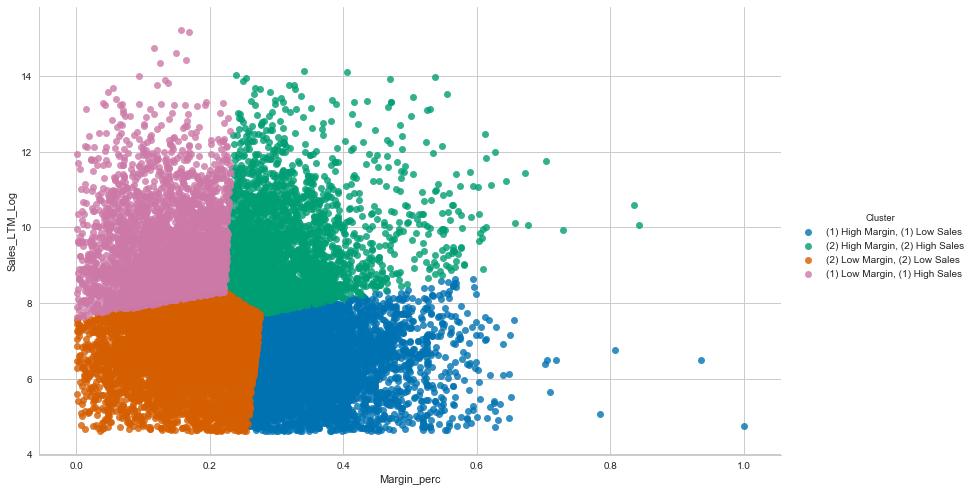

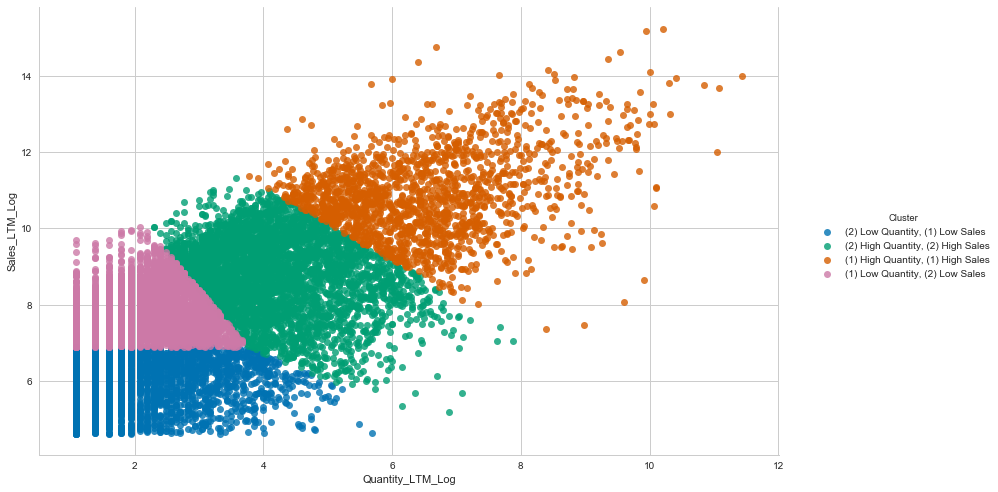

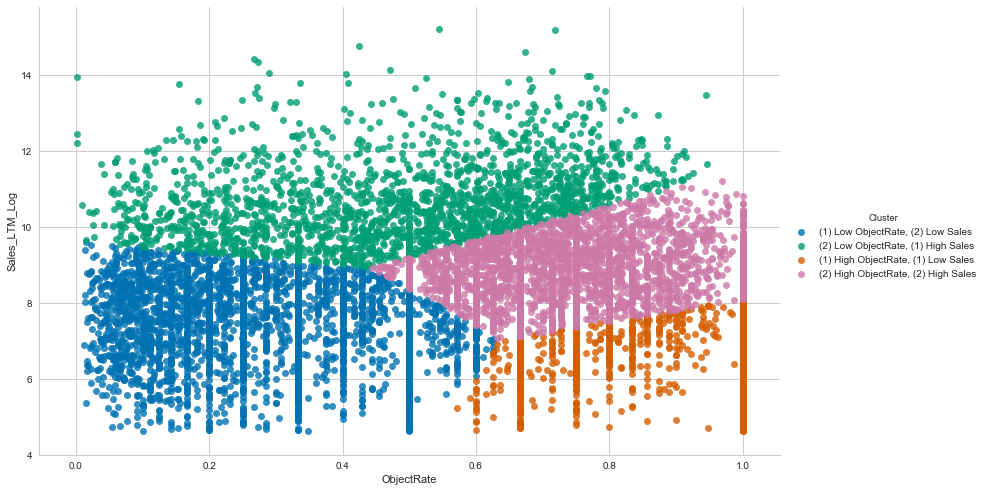

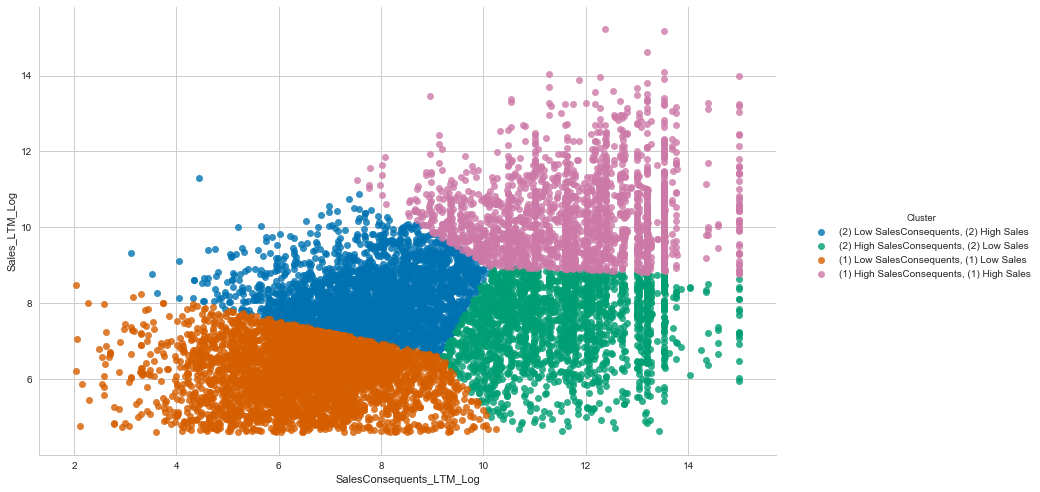

In [48]:
print("Loading and preparing data...")
df = (df.pipe(to_pivot)
        .merge(meta, how='left', left_on='UID', right_on='UniqueId')
        .merge(mbasket, how='left', left_on='UID', right_on="antecedants")
        .pipe(map_consequents)
        .pipe(prep_df)
        .drop_duplicates(inplace=False)
        .pipe(outlier_detection, threshold=2.5)
        .pipe(get_cluster, plot=True)
        .pipe(join_price_group)
        .drop_duplicates(inplace=False))

In [ ]:
print("Writing file...")

dt = datetime.datetime.now()

settings = pp.load_json(os.path.join(pp.Path, "settings.json"))["Sanitary"]
cols = settings['Output Columns']

df = df[cols].drop_duplicates()

#create file with timetag
df.to_csv(
    os.path.join(
    pp.Path, "Analyse",dt.strftime("%Y-%m-%d") + "_Output_Analysis_full.csv"),
    sep="\t", encoding="utf-8", index=False)
df[df['Sales_LTM']>0].to_csv(
    os.path.join(
    pp.Path, "Analyse",
    dt.strftime("%Y-%m-%d") +  "_Output_Analysis_with_sales.csv"),
    sep="\t", encoding="utf-8", index=False)

#create file without timetag, probably to copy it would be better
df.to_csv(
    os.path.join(
    pp.Path, "Analyse","Output_Analysis_full.csv"),
    sep="\t", encoding="utf-8", index=False)
df[df['Sales_LTM']>0].to_csv(
    os.path.join(
    pp.Path, "Analyse", "Output_Analysis_with_sales.csv"),
    sep="\t", encoding="utf-8", index=False)